<a href="https://colab.research.google.com/github/sul01/MSDS-CODE/blob/master/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating prices.csv

In [9]:
import pandas as pd
import numpy as np
import functools 

cad = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw1/USDCAD%3DX.csv")

mxn = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw1/MXN%3DX.csv")

jpy = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw1/JPY%3DX.csv")

sp500 = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw1/%5EGSPC.csv")

#keep close prices only, merge by date, rename columns
data = [cad[['Date','Close']], mxn[['Date','Close']], jpy[['Date','Close']], sp500[['Date','Close']]]

data = functools.reduce(lambda left, right: pd.merge(left, right, on = ['Date'], how = 'outer'), data).dropna()

data.columns = ['Date', 'USD/CAD', 'USD/MXN', 'USD/JPY', 'S&P500']

#reverse the data for descending dates
data = data.iloc[::-1]

#X[t]=set of days t and three previous 
prices = data[data.columns[1:]] #closingPrices

X = pd.DataFrame(columns = ['USDCAD(t)' ,'USDMXN(t)', 'USDJPY(t)', 'S&P500(t)', 
                            'USDCAD(t-1)', 'USDMXN(t-1)', 'USDJPY(t-1)', 'S&P500(t-1)', 
                            'USDCAD(t-2)', 'USDMXN(t-2)', 'USDJPY(t-2)', 'S&P500(t-2)', 
                            'USDCAD(t-3)', 'USDMXN(t-3)', 'USDJPY(t-3)' ,'S&P500(t-3)'])

for i in range(1, prices.shape[0]-4):
  
    X.loc[i-1] = tuple(prices[i:i+4].stack())

#add date and true price columns
X.insert(0, "Date", data['Date'][1:(prices.shape[0]-4)].reset_index(drop=True), True)

X['Y(t)'] = np.array(data['USD/JPY'][0:len(X)])

X.insert(0, "t", range(1,len(X)+1), True)

X.to_csv('prices.csv')

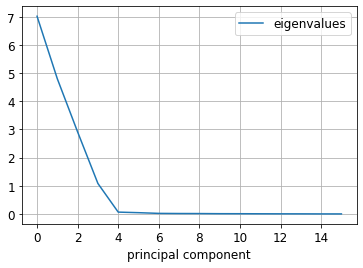

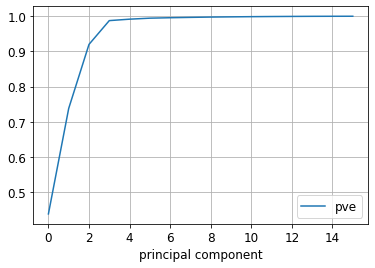

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

prices = pd.read_csv('prices.csv')

X = prices[prices.columns[3:19]]

Xrescaled = preprocessing.StandardScaler().fit_transform(X) #rescale

pca = PCA(n_components=16)

pca.fit_transform(Xrescaled)

eigenvalues = pca.explained_variance_

pve = pca.explained_variance_ratio_.cumsum()

plt.plot(eigenvalues, label = 'eigenvalues'); plt.xlabel('principal component'); plt.legend(); plt.grid(True); plt.show()

plt.plot(pve, label = 'pve'); plt.xlabel('principal component'); plt.legend(); plt.grid(True); plt.show()

h95 = np.where(pve>=0.95)[0][0]+1

#split train/test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xrescaled, np.array(prices['Y(t)']), test_size = 0.20, random_state = 0)

Finding best h

h= 4: 
best_train_loss=1.5888
best_val_loss=2.8665
Rescaled RMSE=0.0155
Average Reletive Error=0.0098


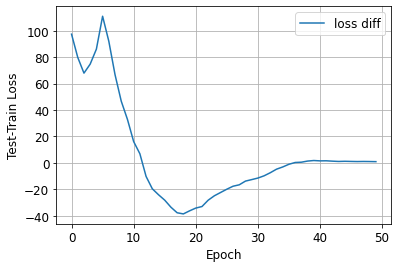

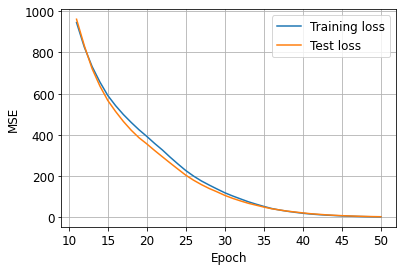

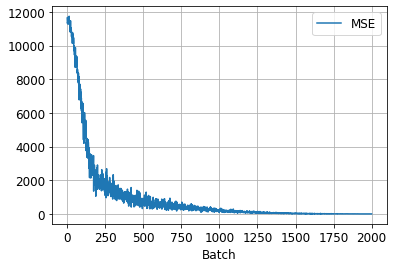

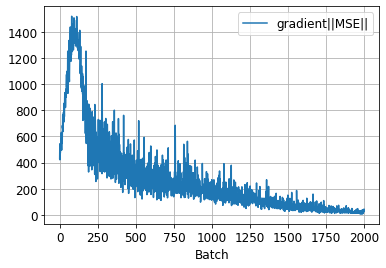

h= 21: 
best_train_loss=0.5570
best_val_loss=0.7071
Rescaled RMSE=0.0077
Average Reletive Error=0.0055


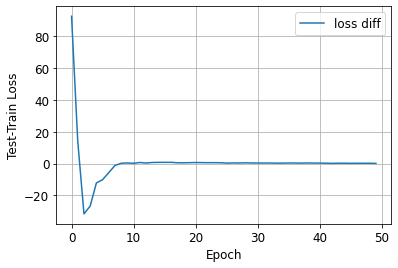

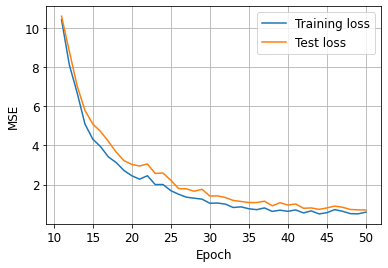

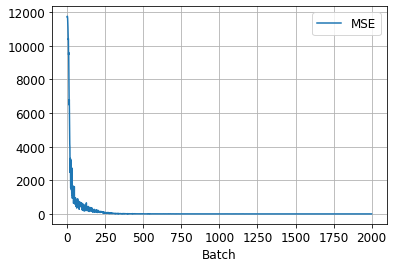

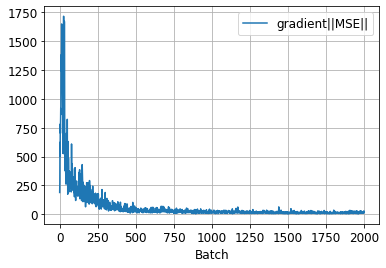

h= 37: 
best_train_loss=0.7210
best_val_loss=0.9951
Rescaled RMSE=0.0091
Average Reletive Error=0.0067


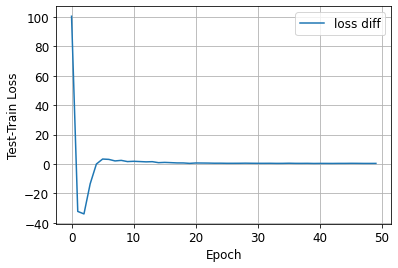

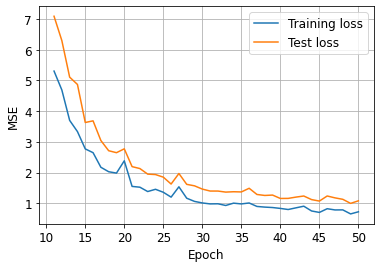

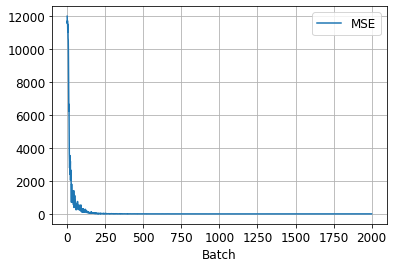

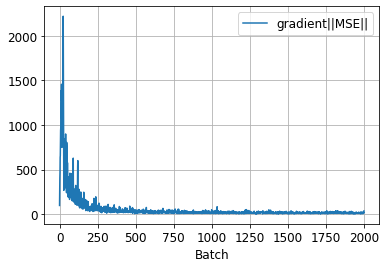

h= 54: 
best_train_loss=0.8155
best_val_loss=1.1926
Rescaled RMSE=0.0100
Average Reletive Error=0.0077


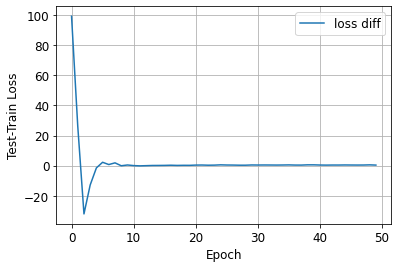

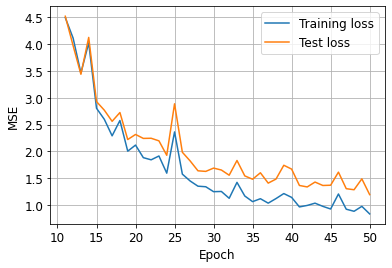

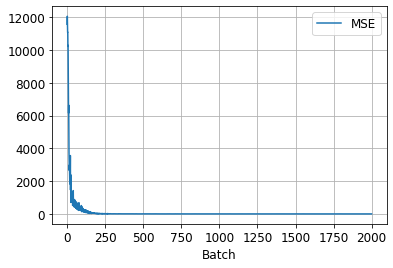

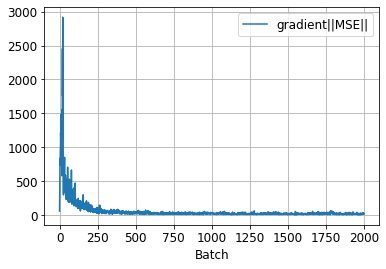

In [11]:
import tensorflow as tf
from tensorflow.keras import losses, optimizers, callbacks
from tensorflow.keras.models import load_model
tf.get_logger().setLevel('ERROR') #surpress logging 

train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(25)

loss_fn = losses.MeanSquaredError()

optimizer=optimizers.Adam(learning_rate = 0.01)

hmax = int(np.floor((Xtrain.shape[0]-1)/18)) #18h+1<=trainingCases

avgRelErr= []

h = np.round(np.linspace(h95, hmax, 4))

best_h_loss = [0,1000]

for i in h: #find best h

  model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(i, activation='relu', input_shape=(16,)),
  tf.keras.layers.Dense(1, activation='relu')])

  model.compile(optimizer=optimizer, loss=loss_fn)

  batch_loss = []; gradsNorm = []; epoch_loss = []; val_loss = []

  best_val_loss = model.evaluate(Xtest,Ytest,verbose=0)

  best_train_loss=model.evaluate(Xtrain,Ytrain,verbose=0)

  #tune `epochs` according to your data
  epochs = 50

  for epoch in range(epochs):
    #print("\nStart of epoch %d" % (epoch,))
    #MSE losses for each epoch

    epoch_loss_value = model.evaluate(Xtrain, Ytrain, verbose = 0)

    epoch_loss.append(epoch_loss_value)

    val_loss_value = model.evaluate(Xtest, Ytest, verbose = 0)

    val_loss.append(val_loss_value)

    #print("epoch_loss: %.4f - val_loss:%.4f" %  (float(epoch_loss_value), float(val_loss_value) )    )

    #Batch to batch MSE and gradient||MSE||
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

      with tf.GradientTape() as tape:

        y_batch_pred = model(x_batch_train, training=True)

        loss_value = loss_fn(y_batch_train, y_batch_pred)

      grads = tape.gradient(loss_value, model.trainable_weights)

      gradsNorm.append(   np.sqrt( sum( [ np.sum( np.square(g.numpy()))  for g in grads ] ) )  )

      batch_loss.append(loss_value.numpy())

      optimizer.apply_gradients( zip( grads,model.trainable_weights ) )

    if val_loss_value < best_val_loss: #update model

      best_val_loss = val_loss_value

      best_train_loss = model.evaluate(Xtrain ,Ytrain, verbose = 0)

      model.save('bestModel%d'%i)

      if best_val_loss<best_h_loss[1]:

        best_h_loss=[i,best_val_loss]

  #UPDATE: rescaled RMSE performance
  avnorm = sum(abs(Ytest))*(1/len(Ytest))
  rescaledRMSE = best_val_loss**0.5/avnorm

  #average relative errors
  Ypred = model.predict(Xtest).flatten()
  relErr = 0
  for n in range(len(Ytest)):
    relErr += abs(Ytest[n]-Ypred[n])/abs(Ytest[n])
  avRelErr = 1/len(Ytest)*relErr
  avgRelErr.append(avRelErr)
  print('h= %d: \nbest_train_loss=%.4f\nbest_val_loss=%.4f\nRescaled RMSE=%.4f\nAverage Reletive Error=%.4f'%(i,best_train_loss,best_val_loss,rescaledRMSE,avRelErr))
 
  loss_diff = []

  for i in range(len(epoch_loss)):
    loss_diff.append(val_loss[i]-epoch_loss[i])

  #plot MSE on training/test sets
  #plt.plot(epoch_loss, label = 'Training loss')

  #plt.plot(val_loss, label = 'Test loss')

  #plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.grid(True); plt.show()

  plt.plot(loss_diff, label = 'loss diff'); plt.xlabel('Epoch'); plt.ylabel('Test-Train Loss'); plt.legend(); plt.grid(True); plt.show()

  #UPDATE: looking at after 10 epoches
  plt.plot(range(11,51),epoch_loss[10:], label='Training loss'); plt.plot(range(11,51),val_loss[10:], label='Test loss'); plt.xlabel('Epoch')
  plt.ylabel('MSE'); plt.legend(); plt.grid(True); plt.show()

  #plot batch to batch evolution
  plt.plot(batch_loss, label = 'MSE'); plt.xlabel('Batch'); plt.legend(); plt.grid(True); plt.show()

  plt.plot(gradsNorm, label = 'gradient||MSE||'); plt.xlabel('Batch'); plt.legend(); plt.grid(True); plt.show()

Result for h=h*

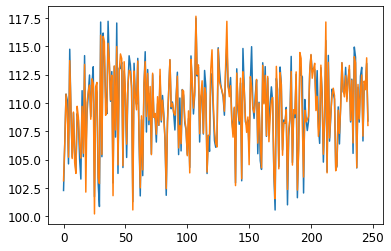

In [12]:
#h_best = int(best_h_loss[0])

#UPDATE: choosing best based on lowest average relative error
h_best = int(h[np.where(avgRelErr == min(avgRelErr))][0])

bestModel = tf.keras.models.load_model('bestModel%d'%h_best)

BestRes = bestModel.predict(Xtest)

predicted = []

for i in range(len(BestRes.tolist())):
  predicted += BestRes.tolist()[i]

true = Ytest.tolist()

plt.plot(predicted, label = "Predicted")

plt.plot(true, label = "True")



In [13]:
h_best

21

Neuron Activity for h=h*

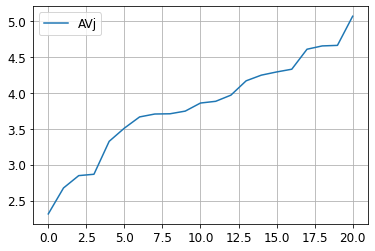

In [14]:
activity = bestModel.layers[0](Xrescaled).numpy()

AVj =[]

for i in range(h_best): AVj.append(np.mean(activity[:, i]))

AVj_sorted = sorted(list(enumerate(AVj)), key = lambda x:x[1])

plt.plot([j[1] for j in AVj_sorted], label = 'AVj'); plt.legend(); plt.grid(True); plt.show()

top3 = [j[0] for j in AVj_sorted][-3:]

last3 = [j[0] for j in AVj_sorted][0:3]

#most active
NRa=top3[-1]

w = bestModel.get_weights()[0][:, NRa] #weights linking NRa to input

w_sorted = -np.sort(-w)

#most inactive
NRi=last3[0]

wi = bestModel.get_weights()[0][:, NRi] #weights linking NRi to input

wi_sorted = -np.sort(-wi)

#Updates

time series plots

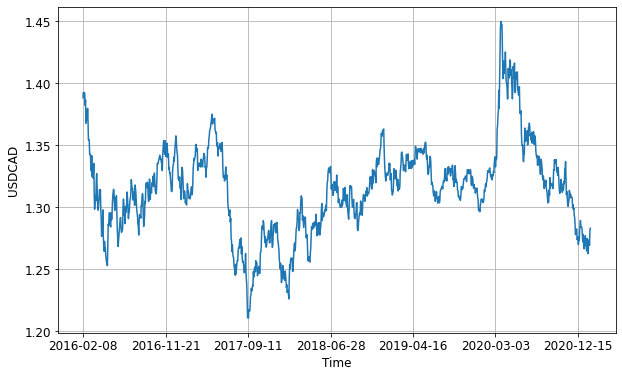

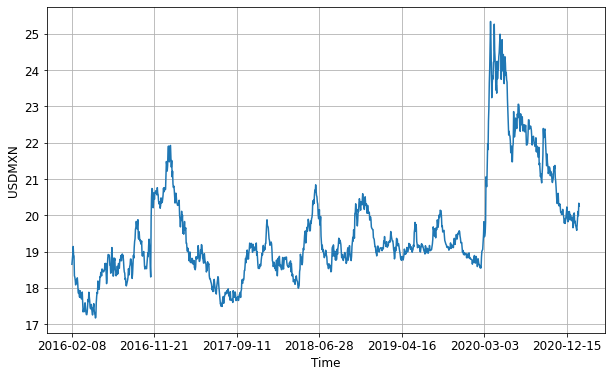

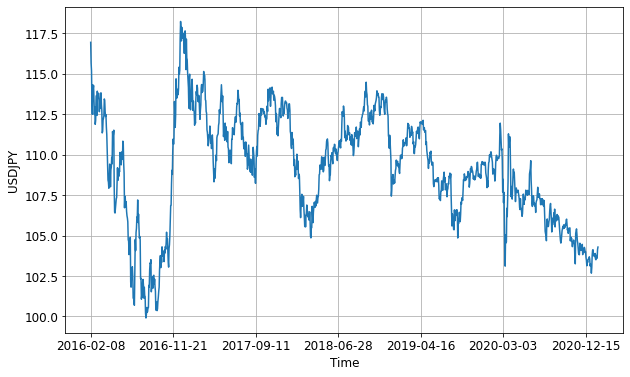

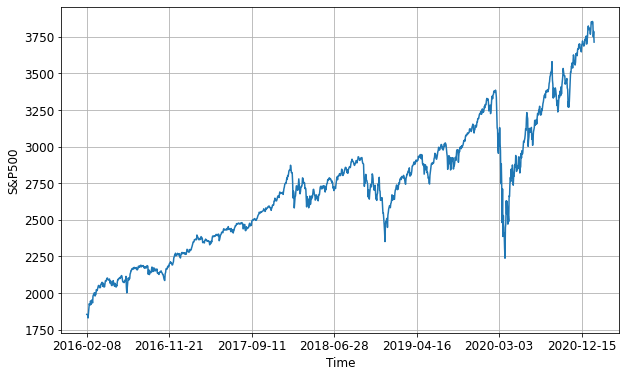

In [15]:
def displayPrice(cur):
  plt.rc('font', size=12)
  fig, ax = plt.subplots(figsize=(10, 6))

  ax.plot(prices['Date'][::-1],prices[cur][::-1])
  ax.set_xlabel('Time')
  ax.set_ylabel(cur[:6])
  ax.grid(True)

  loc = plticker.MultipleLocator(base=200) # this locator puts ticks at regular intervals
  ax.xaxis.set_major_locator(loc)

for cur in prices.columns[3:7]:
  displayPrice(cur)

normalized on same plot

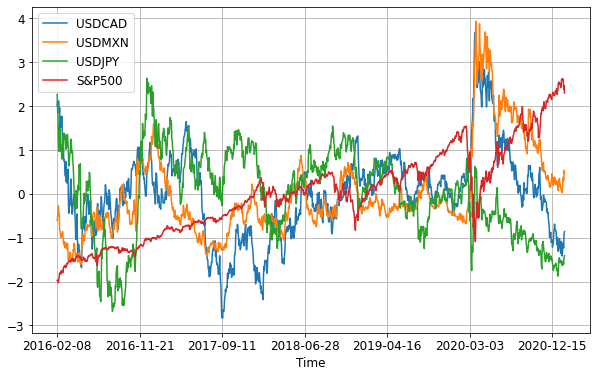

In [16]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

rescaled = pd.DataFrame(Xrescaled)
for i in range(4):
  ax.plot(prices['Date'][::-1],rescaled[rescaled.columns[i]][::-1], label = prices.columns[i+3][:6])

ax.set_xlabel('Time')
ax.legend(); ax.grid(True)

loc = plticker.MultipleLocator(base=200) 
ax.xaxis.set_major_locator(loc)

actual and predicted

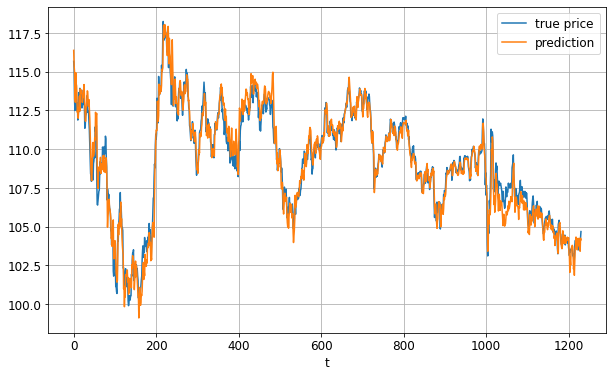

In [17]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.array(prices['Y(t)'])[::-1], label='true price')
ax.plot(bestModel.predict(Xrescaled)[::-1], label = 'prediction')
ax.set_xlabel('t')
ax.legend(); ax.grid(True)

loc = plticker.MultipleLocator(base=200)
ax.xaxis.set_major_locator(loc)

remove least active neuron

Rescaled RMSE=0.0099
Average Reletive Error=0.0074



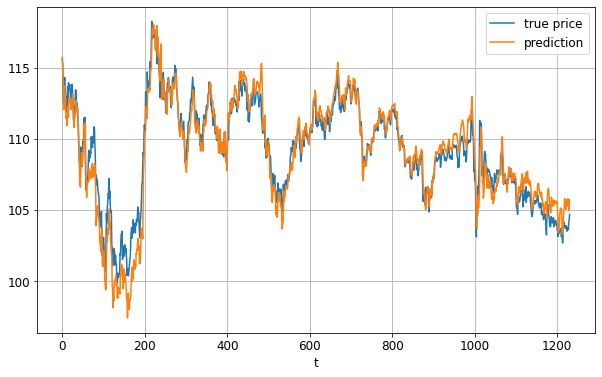

In [18]:
#'eliminate' the least active neuron by setting its weights to 0
bestModel_elim = tf.keras.models.load_model('bestModel%d'%h_best)
bestModel_elim.layers[0].weights[0][:,NRi].assign(np.zeros(16))

#rescaled RMSE
MSE = bestModel_elim.evaluate(Xtest,Ytest,verbose=0)
avnorm = sum(abs(Ytest))*(1/len(Ytest))
rescaledRMSE = MSE**0.5/avnorm

#average relative errors
Ypred = bestModel_elim.predict(Xtest).flatten()
relErr = 0
for n in range(len(Ytest)):
  relErr += abs(Ytest[n]-Ypred[n])/abs(Ytest[n])
avRelErr = 1/len(Ytest)*relErr

print('Rescaled RMSE=%.4f\nAverage Reletive Error=%.4f\n'%(rescaledRMSE,avRelErr))

#plot performance
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.array(prices['Y(t)'])[::-1], label='true price')
ax.plot(bestModel_elim.predict(Xrescaled)[::-1], label = 'prediction')
ax.set_xlabel('t')
ax.legend(); ax.grid(True)
loc = plticker.MultipleLocator(base=200)
ax.xaxis.set_major_locator(loc)
